In [1]:
using Pkg
using Distributed 


In [2]:
addprocs(50);

In [3]:
using Random, Plots, DifferentialEquations
@everywhere using SciPy
using Catalyst, LinearAlgebra
using ApproxBayes
using Clustering

In [4]:
@everywhere using StatsBase, Distributions, OptimalTransport

In [5]:
@everywhere using LinearAlgebra

In [6]:
@everywhere using Distances

In [7]:
stem_model = @reaction_network begin
    (k0*O*(c0 + c1*N^2 + k0*O + c2*L))/(1 + (k0*O*(c1*N^2 + k0*O + c2*L + c3*F^2)) + c4*O*G^2), ∅ --> N
    (e0 + e1*O)/(1 + e1*O + e2*G^2), ∅ --> O
    (a0 + a1*O)/(1 + a1*O), ∅ --> F
    (b0 + b1*G^2 + b3*O)/(1 + b1*G^2 + b2*N^2 + b3*O), ∅ --> G
    γ, N -->∅
    γ, O -->∅
    γ, F -->∅
    γ, G -->∅
end k0 c0 c1 c2 c3 c4 e0 e1 e2 a0 a1 b0 b1 b2 b3 γ L

p = [0.005, 0.01, 0.4, 1, 0.1, 0.00135, 0.01, 1, 1, 0.01, 1.0, 0.005, 0.005, 1.0, 1, 0.01, 50]
T = 3000.0
u₀ = [105,110,100,5]
tspan = (0.0,T)
dprob = DiscreteProblem(stem_model, u₀, tspan, p)
jprob = JumpProblem(stem_model, dprob, Direct(),save_positions=(false,false))


function Generating_data(param,n,T)
    timept = 10:div(T, 7):T
    ensprob = EnsembleProblem(jprob,prob_func=(p,i,r)->remake(p,p = param), safetycopy=false)
    
    sol = solve(ensprob, SSAStepper(),EnsembleThreads(), trajectories=n,saveat=1)
    data = hcat(sol[1].u...)[:,timept]
    for i in 2:n
        data = cat(data,hcat(sol[i].u...)[:,timept], dims=3)
    end
    return data
end

Generating_data (generic function with 1 method)

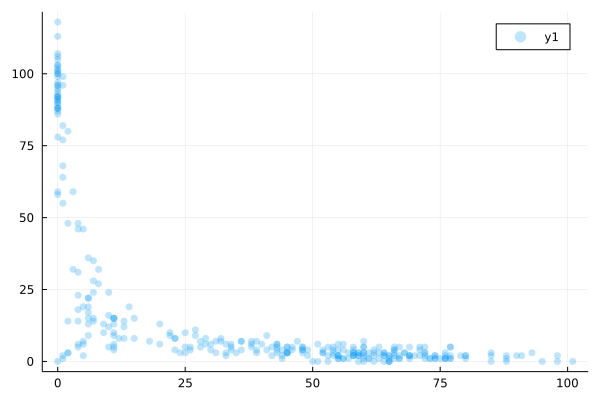

In [8]:
X_final = Generating_data(p,300,3000)
scatter(X_final[1, 10,:], X_final[4, 10,:]; markerstrokewidth = 0, alpha = 0.25)

In [9]:
# get the range of density 
function get_densityrange(data)
    observation_range = zeros(4,10,2)
    for i in 1:4
        for j in 1:10
            observation_range[i,j,1] = minimum(data[i,j,:])
            observation_range[i,j,2] = maximum(data[i,j,:])
        end
    end
    return observation_range
end

get_densityrange (generic function with 1 method)

In [10]:
# using the kde method to generate 4 dimensional joint density function 
# at one time point (t) based on the range of data
@everywhere function generate_density4d(observations1, observations2, observations3,observations4, t, observation_range)
    granularity_2d = 35

    x1_range = Array(LinRange(observation_range[1,t,1], maximum(observation_range[1,t,2]), granularity_2d))
    x2_range = Array(LinRange(observation_range[2,t,1], maximum(observation_range[2,t,2]), granularity_2d))
    x3_range = Array(LinRange(observation_range[3,t,1], maximum(observation_range[3,t,2]), granularity_2d))
    x4_range = Array(LinRange(observation_range[4,t,1], maximum(observation_range[4,t,2]), granularity_2d))
    x_grid = [[_x1, _x2,_x3,_x4] for _x1 in x1_range for _x2 in x2_range for _x3 in x3_range for _x4 in x4_range]
    values = hcat([observations1, observations2, observations3, observations4]...)'
    kernel = SciPy.stats.gaussian_kde(values, "silverman")

    position = hcat(x_grid...)
    
    densitys = kernel(position)
    return densitys
end



In [11]:
#generating the joint density(potential) at all the selected time points 
function generating_potential(t, chains, observation_range)
    potential = zeros(35^4,t)
    @sync for i in 1:t
        @async potential[:,i] += remotecall_fetch(generate_density4d,i+1,chains[1,i,:], chains[2,i,:], chains[3,i,:], chains[4,i,:], i,observation_range) 
    end
    return potential
end


generating_potential (generic function with 1 method)

In [12]:
@everywhere function mmd2(x, y)
    # x shape [n, d] y shape [m, d]
    # n_perm number of bootstrap permutations to get p-value, pass none to not get p-value
    d, n = size(x)
    d, m = size(y)
    xy = cat(x,y, dims = 2)
    dists = Distances.pairwise(Euclidean(), xy,xy)
    sigma = median(dists)/2
    # we are a bit sloppy here as we just keep the diagonal and everything twice
    # note that sigma should be squared in the RBF to match the Gretton et al heuristic
    k = exp.((-1/(2*sigma^2)) * dists.^2) + Matrix(I, n+m, n+m)*1e-5
    k_x = k[1:n, 1:n]
    k_y = k[n+1:end, n+1:end]
    k_xy = k[1:n, n+1:end]
    # The diagonals are always 1 (up to numerical error, this is (3) in Gretton et al.)
    # note that their code uses the biased (and differently scaled mmd)
    mmd = sum(k_x) / (n * (n - 1)) + sum(k_y) / (m * (m - 1)) - 2 * sum(k_xy) / (n * m)
    return mmd
end 

#Optimal Transport (sinkhorn divergence)
function loss(x,y,ε)
    n = 300
    μ = fill(1/n, n)
    ν = fill(1/n, n)
    C_μ = Distances.pairwise(SqEuclidean(), y)
    C_μν = Distances.pairwise(SqEuclidean(), y, x;dims = 2)
    C_ν = Distances.pairwise(SqEuclidean(), x)
    scale = mean([mean(C_μ), mean(C_μν), mean(C_ν)])
    # return sinkhorn2(μ, ν, C_μν, ε*mean(C_μν))
    return sinkhorn_divergence(
        μ, ν, C_μν/scale, C_μ/scale, C_ν/scale, ε; maxiter = 5_000, atol=1e-6, rtol = 1e-3, regularization=false
    )
end
#log transformed probability of cells in pluripotent states
function do_kmean(data)
    a = kmeans(data[:,10,:],2)
    ct = 0
    if a.centers[1,1] > a.centers[2,2]
        ct = sum(a.assignments .== 1)/300
    else
        ct = sum(a.assignments .== 2)/300
    end
    return log(ct+10^(-9)/(1-ct)+10^(-9))
end

In [19]:
#get density distribution of data for ABC-SMC with Bhattacharyya distance 
obr1 = get_densityrange(X_final);
density1 = generating_potential(10,X_final, obr1);

  0.110162 seconds (5.51 M allocations: 338.653 MiB)


In [20]:
# simulating 300 chains 
function simdata(x)
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16 = x
    param = [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16,50]
    data = Generating_data(param,300,3000)
    return data
end

# simulating 300 chains and get it's joint density(potential) at each time point for bhattacharyya distance
function simdata_bhatt(x)
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16 = x
    param = [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16]
    data = Generating_data(param,300,3000)+rand(Normal(0.025,0.025), 4, 10, 300)
    dens = generating_potential(10,data,obr1)
    return dens
end

# calculate the bhattacharyya distance between 2 density(potential)
# through all the timepoints
function my_bhattacharyya(x,y)
   @distributed (+) for i =1:10
                        bhattacharyya(x[:,i],y[:,i])
                    end
end
# MMD for all the time points
function my_mmd(x,y)
    @distributed (+) for i = 1:10
                        mmd2(x[:,i,:],y[:,i,:])
                     end
    
end

function my_sinkhorn(x,y)
    @distributed (+) for i = 1:10
                        loss(x[:,i,:],y[:,i,:], 0.025)
                     end
end

function my_kmean(x,y)
    return euclidean(do_kmean(x), do_kmean(y))
end

#function for ABC-SMC(modify the simulation function/distance metric for other metrics)
function simdist(x, constants, y)
  s = simdata(x)
  my_mmd(s,y), 1
end


simdist (generic function with 1 method)

In [26]:
# running abc-smc for mmd (modifying the simdist function for other metrics)
# typical running time for mmd and OptimalTransport would be around 3-4 days on a 50 cpu cluster
# for bhattacharyya distance it would be around 7-10 days 
setup = ABCSMC(simdist, #simulation function
  16, # number of parameters
    0.06, #target ϵ
  Prior([Uniform(0.00050, 0.05000), Uniform(0.00100, 0.02500), 
            Uniform(0.04000, 1.0000), Uniform(0.10000, 2.00000),
            Uniform(0.01000, 0.50000), Uniform(0.00035, 0.00200),
            Uniform(0.00100, 0.02500), Uniform(0.10000, 2.00000),
             Uniform(0.10000, 2.00000),Uniform(0.00100, 0.02500),
            Uniform(0.10000, 2.00000),Uniform(0.00050, 0.05000),
            Uniform(0.00050, 0.05000),Uniform(0.10000, 2.00000),
            Uniform(0.10000, 2.00000),Uniform(0.00100, 0.02500)]),
    nparticles=1000,
    maxiterations = 10^7
  )
smc = runabc(setup, X_final, verbose = true, progress = true)

Running ABC rejection algorithm...100%|██████████████████████████████| Time: 0:02:52
ABC SMC population 1, new ϵ: 3.04...100%|██████████████████████████████| Time: 0:09:38
ABC SMC population 2, new ϵ: 0.78...100%|██████████████████████████████| Time: 0:18:46
ABC SMC population 3, new ϵ: 0.28...100%|██████████████████████████████| Time: 0:55:52
ABC SMC population 4, new ϵ: 0.15...100%|██████████████████████████████| Time: 2:56:57
ABC SMC population 5, new ϵ: 0.1...100%|██████████████████████████████| Time: 7:58:55
ABC SMC population 6, new ϵ: 0.07...100%|██████████████████████████████| Time: 21:55:2651
ABC SMC population 7, new ϵ: 0.06...100%|██████████████████████████████| Time: 3 days, 1:59:41m


##################################################
Use ABC rejection to get first population
Preparing to run in serial on 1 processor
Running ABC SMC... 

Preparing to run in serial on 1 processor
##################################################
Total number of simulations: 4.48e+03
Cumulative number of simulations = [1000, 4475]
Acceptance ratio: 2.23e-01
Tolerance schedule = [3.04, 0.78]

Median (95% intervals):
Parameter 1: 0.03 (0.00,0.05)
Parameter 2: 0.01 (0.00,0.02)
Parameter 3: 0.71 (0.13,0.98)
Parameter 4: 1.14 (0.16,1.97)
Parameter 5: 0.12 (0.02,0.28)
Parameter 6: 0.00 (0.00,0.00)
Parameter 7: 0.01 (0.00,0.02)
Parameter 8: 1.09 (0.17,1.96)
Parameter 9: 1.03 (0.13,1.95)
Parameter 10: 0.01 (0.00,0.02)
Parameter 11: 1.07 (0.15,1.93)
Parameter 12: 0.02 (0.00,0.05)
Parameter 13: 0.03 (0.00,0.05)
Parameter 14: 1.09 (0.17,1.96)
Parameter 15: 1.04 (0.14,1.95)
Parameter 16: 0.01 (0.00,0.02)
##################################################

########################################

Total number of simulations: 1.92e+06
Cumulative number of simulations = [1000, 4475, 10583, 29257, 90417, 260816, 668542, 1920356]
Acceptance ratio: 5.21e-04
Tolerance schedule = [3.04, 0.78, 0.28, 0.15, 0.1, 0.07, 0.06, 0.05]

Median (95% intervals):
Parameter 1: 0.03 (0.00,0.05)
Parameter 2: 0.01 (0.00,0.02)
Parameter 3: 0.68 (0.27,0.96)
Parameter 4: 1.50 (0.55,1.96)
Parameter 5: 0.17 (0.07,0.24)
Parameter 6: 0.00 (0.00,0.00)
Parameter 7: 0.01 (0.00,0.02)
Parameter 8: 1.17 (0.38,1.93)
Parameter 9: 1.31 (0.36,1.96)
Parameter 10: 0.01 (0.00,0.02)
Parameter 11: 1.27 (0.51,1.96)
Parameter 12: 0.02 (0.00,0.05)
Parameter 13: 0.01 (0.00,0.05)
Parameter 14: 1.43 (0.54,1.98)
Parameter 15: 1.38 (0.52,1.94)
Parameter 16: 0.01 (0.00,0.02)
